# Artificial Neural Networks and Deep Learning

---

## Homework 2: U-Net


## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
data = np.load("/kaggle/input/clean-dataset/clean_dataset.npz")

X_train = data["images"]
y_train = data["labels"]
X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [3]:
# Splitting the dataset 80/20 (training and validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

#Display the resulting shapes
print(f"Training images shape: {X_train.shape}, Validation images shape: {X_val.shape}")
print(f"Training masks shape: {y_train.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2004, 64, 128), Validation images shape: (501, 64, 128)
Training masks shape: (2004, 64, 128), Validation masks shape: (501, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")

X_train shape: (2004, 64, 128, 1)
y_train shape: (2004, 64, 128)
X_test shape: (10022, 64, 128, 1)
Number of classes: 5


## 🛠️ Train and Save the Model

In [5]:
# Define hyperparameters
epochs = 200
batch_size = 64

In [6]:
# Define callbacks
# Early stopping to stop the training when val_accuracy stop to increase
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50
)

# Reduce LR when val_loss stop to decrease to avoid local minumum
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=20
)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [7]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [8]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    down_block_3 = tfkl.Dropout(0.5)(down_block_3)
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 512, name='bottleneck')
    bottleneck = tfkl.Dropout(0.5)(bottleneck)
    
    # Upsampling path
    u3 = tfkl.UpSampling2D()(bottleneck)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 256, name='up_block3_')
    
    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [9]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tfk.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = tfk.layers.concatenate([x, conv_features])
    # dropout
    x = tfk.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [10]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tfk.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [11]:
def generalized_dice_loss(y_true, y_pred, num_classes):
    
    # Convert integer labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (class 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Remove the first channel (background)
    y_pred = y_pred[..., 1:]  # Remove the first channel (background)
    
    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute per-class weights
    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(0, 1, 2))
    weights = 1 / (tf.reduce_sum(y_true_one_hot, axis=(0, 1, 2)) ** 2 + 1e-6)
    
    # Generalized Dice Score
    dice_score = tf.reduce_sum(weights * numerator) / tf.reduce_sum(weights * denominator)
    
    # Loss is 1 - Dice Score
    return 1 - dice_score

def combined_loss(y_true, y_pred):
    return ensemble_loss(y_true, y_pred)


def ensemble_loss(y_true, y_pred, num_classes=5, alpha=0.5, beta=0.25, gamma=0.25):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (label 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Ignore background in ground truth
    y_pred = y_pred[..., 1:]  # Ignore background in predictions

    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # 1. Dice Loss
    class_weights = 1 / (tf.reduce_sum(y_true_one_hot, axis=(0, 1, 2)) + 1e-6)
    numerator = 2 * tf.reduce_sum(y_true_one_hot * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(0, 1, 2))
    dice_loss = 1 - tf.reduce_sum(class_weights * numerator) / tf.reduce_sum(class_weights * denominator)
    
    # 2. Focal Loss
    gamma_focal = 2.0
    focal_loss = -tf.reduce_mean(
        tf.reduce_sum(
            y_true_one_hot * ((1 - y_pred) ** gamma_focal) * tf.math.log(y_pred), axis=-1
        )
    )
    
    # 3. Boundary Loss (using corrected Sobel filters)
    sobel_filter_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
    sobel_filter_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
    sobel_filter_x = sobel_filter_x[:, :, tf.newaxis, tf.newaxis]
    sobel_filter_y = sobel_filter_y[:, :, tf.newaxis, tf.newaxis]

    def apply_sobel(image):
        grad_x = tf.nn.conv2d(image, sobel_filter_x, strides=[1, 1, 1, 1], padding="SAME")
        grad_y = tf.nn.conv2d(image, sobel_filter_y, strides=[1, 1, 1, 1], padding="SAME")
        return tf.sqrt(tf.square(grad_x) + tf.square(grad_y))

    y_true_grad = apply_sobel(tf.reduce_sum(y_true_one_hot, axis=-1, keepdims=True))
    y_pred_grad = apply_sobel(tf.reduce_sum(y_pred, axis=-1, keepdims=True))
    boundary_loss = tf.reduce_mean(tf.abs(y_true_grad - y_pred_grad))
    
    # Combine the losses with weights
    total_loss = alpha * dice_loss + beta * focal_loss 
    
    return total_loss

In [12]:
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Define the MeanIoU ignoring the background class
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
optimizer = tfk.optimizers.AdamW()

model.compile(
    loss=[combined_loss],
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)

model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [13]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_mean_iou = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation MEAN iou: {final_val_mean_iou}%')

# Save the trained model to a file with the timestamp included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Epoch 1/200


I0000 00:00:1733217821.512296      75 service.cc:145] XLA service 0x795694002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733217821.512371      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20:03 39s/step - accuracy: 0.1666 - loss: 0.7272 - mean_iou: 0.0802

I0000 00:00:1733217851.791092      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3160 - loss: 0.6332 - mean_iou: 0.1610 - val_accuracy: 0.2144 - val_loss: 2.6869 - val_mean_iou: 0.0399 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4260 - loss: 0.5350 - mean_iou: 0.2394 - val_accuracy: 0.1979 - val_loss: 2.6222 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4305 - loss: 0.4914 - mean_iou: 0.2540 - val_accuracy: 0.1979 - val_loss: 2.6206 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4946 - loss: 0.4455 - mean_iou: 0.3648 - val_accuracy: 0.1979 - val_loss: 2.4043 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.5503 - loss: 0.4092 - mean_iou: 0.3642 - val_accuracy: 0.1979 - val_loss: 2.5929 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 

NameError: name 'model' is not defined

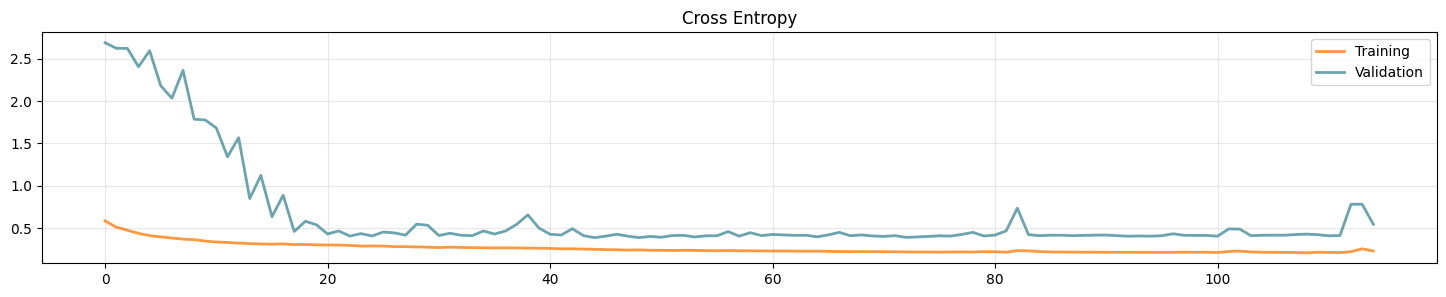

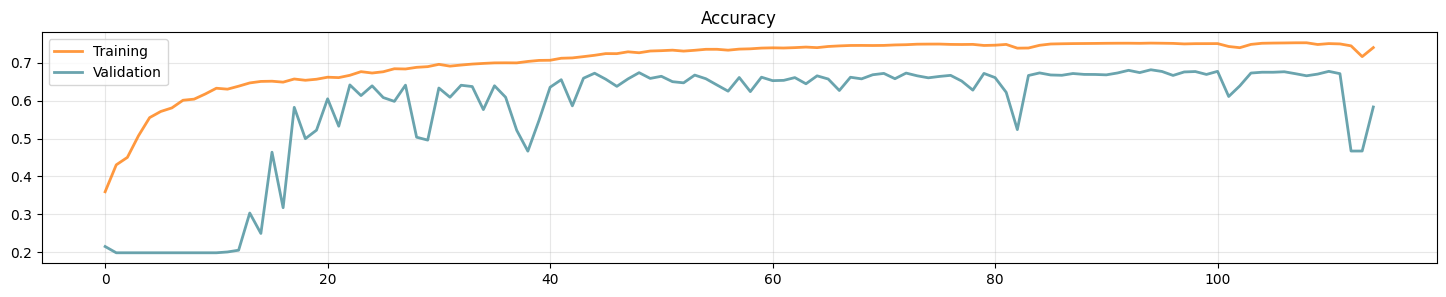

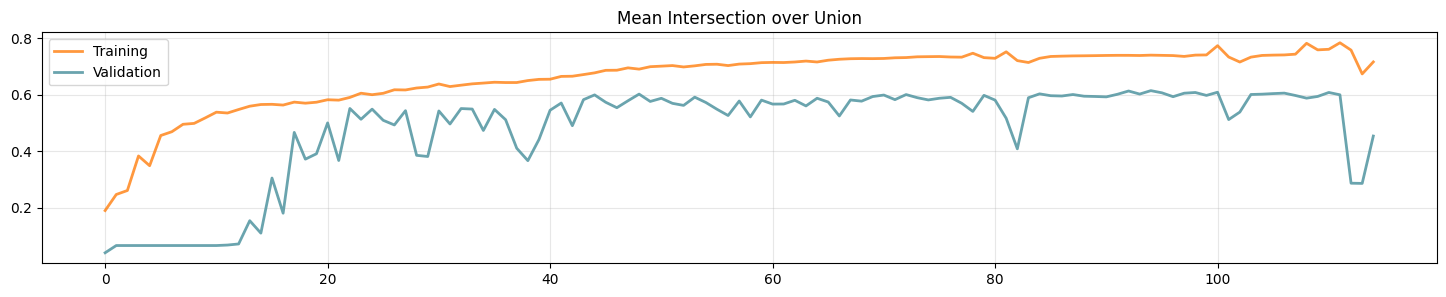

In [14]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [15]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [16]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241203_093526.keras


In [17]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step
Predictions shape: (10022, 64, 128)


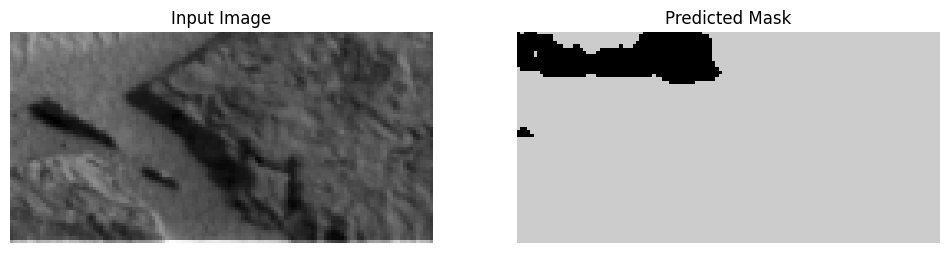

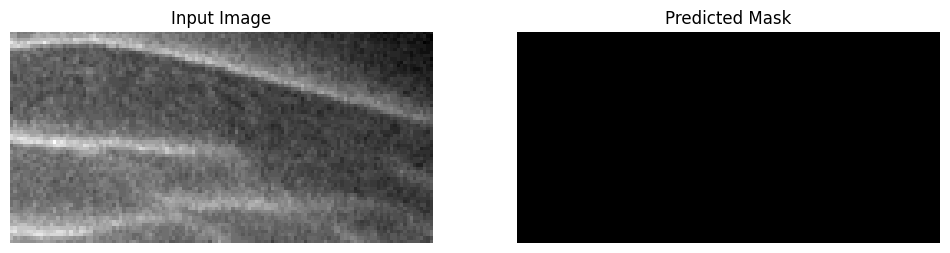

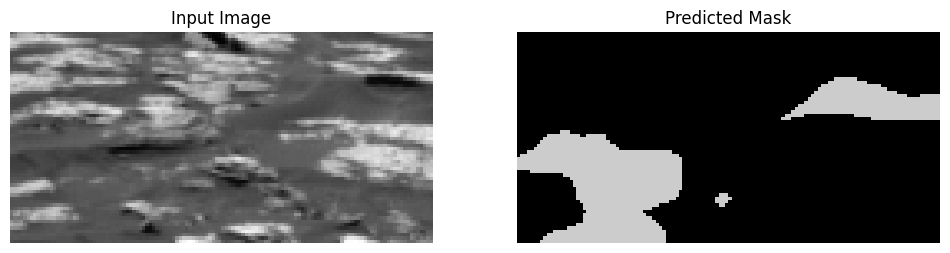

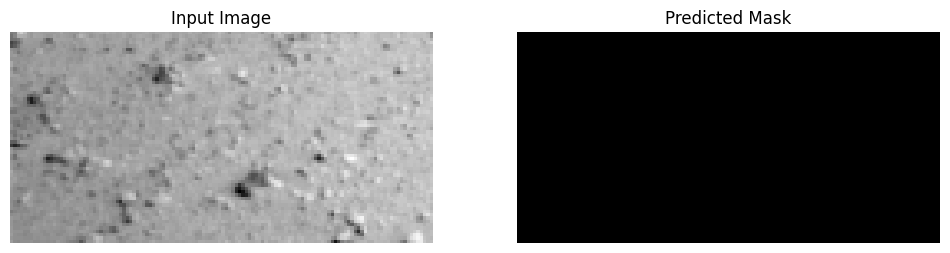

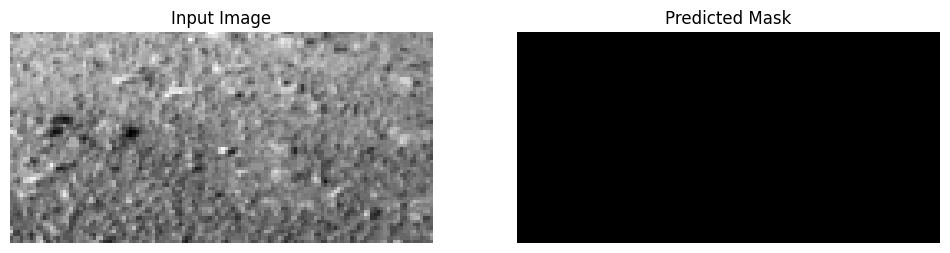

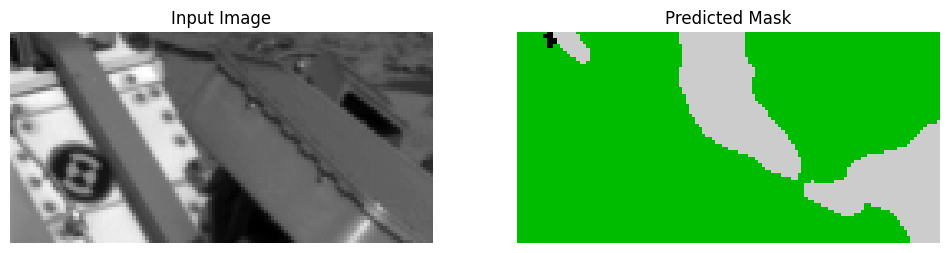

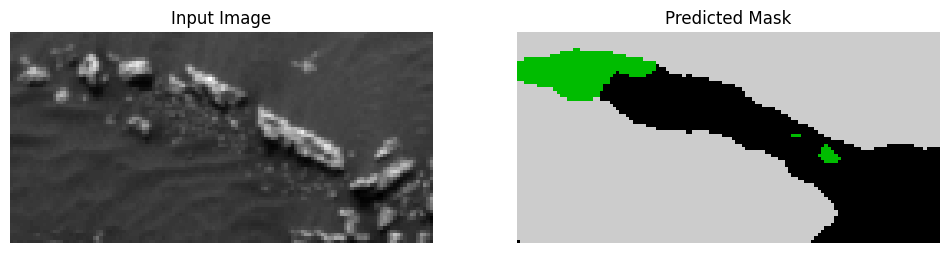

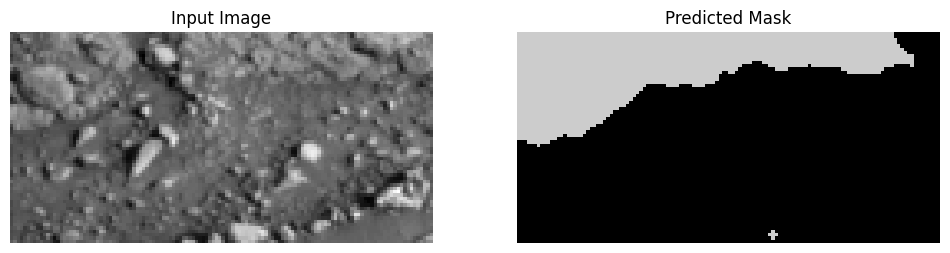

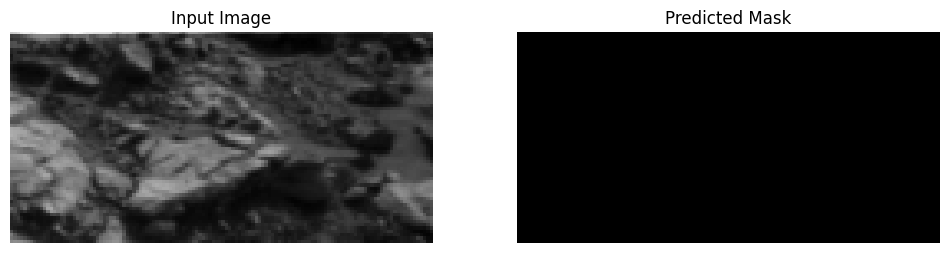

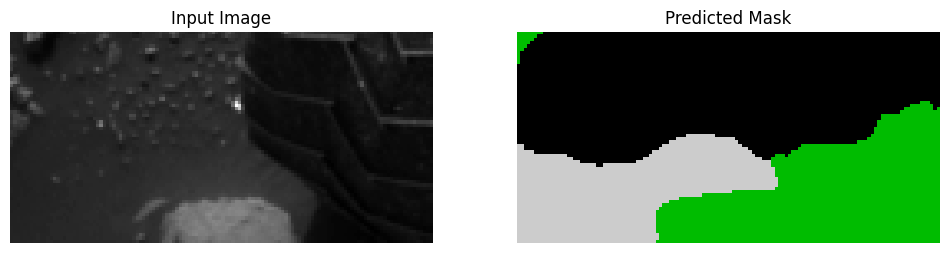

In [18]:
num_samples_to_display = 10  # Adjust as needed
for i in range(num_samples_to_display):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')  # Adjust for RGB if needed
    plt.title("Input Image")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(preds[i], cmap='nipy_spectral')  # Colorful mask
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

In [19]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [20]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)